In [1]:
from losses import *

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg
plt.style.use('fivethirtyeight')
mpl.rcParams.update({'legend.fontsize': 13.0, 'axes.labelsize': 'large', 
                     'xtick.labelsize':'medium','ytick.labelsize':'medium', 'figure.figsize': (16,9)})

In [3]:
# print(plt.style.available)

### Calculate the entropy-regularized 2-Wasserstein distance and the dual potentials for Gaussians

#### Here we check how precise are the optimal dual potentials when estimating the 2-Wasserstein distance on a sample

First define the data dimension and the number of points

In [4]:
n_pts_to_calculate_distance = 256
data_dim = 32
data_shape = (n_pts_to_calculate_distance, data_dim)

Generate random means and covariances for X and Y variables and their samples

In [5]:
mean_x = np.random.randn(data_dim)
mean_y = np.random.randn(data_dim)
K_x = np.random.randn(data_dim, data_dim)
K_x = K_x.dot(np.diag(np.random.uniform(0, 10, data_dim))).dot(K_x.T)
K_x /= np.linalg.norm(K_x)
K_y = np.random.randn(data_dim, data_dim)
K_y = K_y.dot(np.diag(np.random.uniform(0, 10, data_dim))).dot(K_y.T)
K_y /= np.linalg.norm(K_y)

# Generate the samples
x = np.random.randn(*data_shape)
y = np.random.randn(*data_shape)

x = x.dot(scipy.linalg.sqrtm(K_x)) + mean_x
y = y.dot(scipy.linalg.sqrtm(K_y)) + mean_y

Note the errors (in Frobenius norm since the covariance matrices are normalized to have Frobenius norm 1) in estimating the covariance matrix

In [6]:
print("Error in estimating K_x: {:.5e}\nError in estimating K_y: {:.5e}".format(np.linalg.norm(np.cov(x.T) - K_x), 
                                                                                np.linalg.norm(np.cov(y.T) - K_y)))

Error in estimating K_x: 2.77395e-01
Error in estimating K_y: 2.60538e-01


Define the range of regularization parameters and actually calculate the entropic 2-Wasserstein distance and its dual potentials

In [7]:
eps_list = np.power(10., np.arange(-6, 6))

In [8]:
entropicW_distance_true = [true_entropic_2Wasserstein_loss_gaussian(mean_x,mean_y,K_x,K_y, eps) 
                           for eps in eps_list]
dual_potentials_true = [true_entropic_2Wasserstein_loss_dual_potentials_gaussian(mean_x,mean_y,K_x,K_y, eps) 
                           for eps in eps_list]

In [9]:
x = torch.tensor(x).double()
y = torch.tensor(y).double()

In [10]:
entropicW_distance_via_dual_potentials = np.stack([(dual_potentials_true[i][0](x).mean()\
        + dual_potentials_true[i][1](y).mean()).numpy() if type(x) == torch.Tensor
               else dual_potentials_true[i][0](x).mean() + dual_potentials_true[i][1](y).mean()
      for i in range(len(eps_list))])

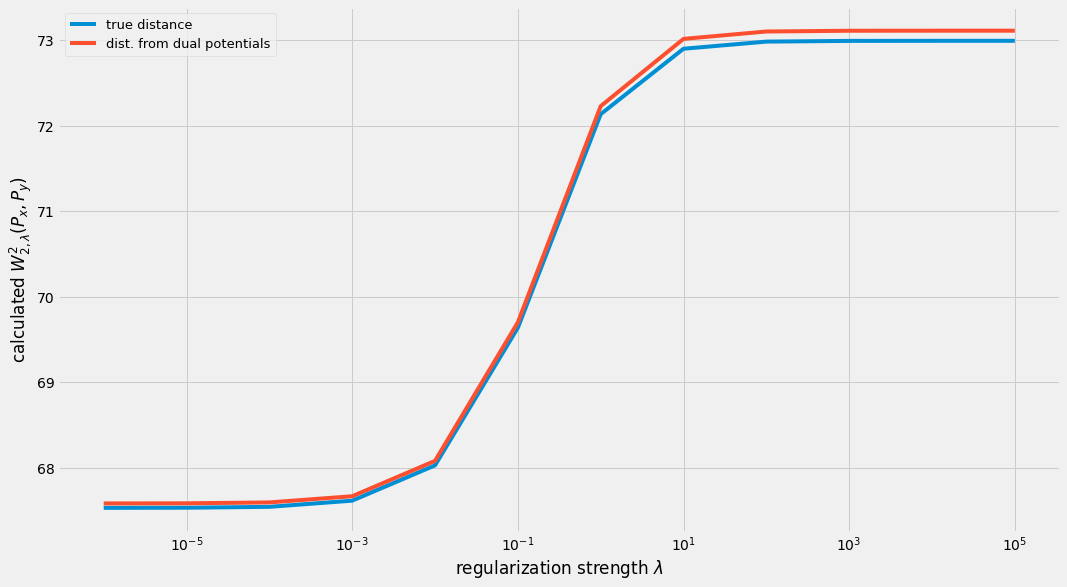

In [11]:
plt.figure()
plt.semilogx(eps_list, entropicW_distance_true)
plt.semilogx(eps_list, entropicW_distance_via_dual_potentials)
plt.xlabel('regularization strength $\lambda$')
plt.ylabel('calculated $W_{2,\lambda}^2(P_x, P_y)$')
plt.legend(['true distance', 'dist. from dual potentials'])
plt.grid('on', 'both')
plt.show()

Relative mismatch averaged over n_trials samples of mcovariances and data

In [12]:
n_trials = 100

In [13]:
n_pts_to_calculate_distance_list = [256, 1024, 2048]

In [14]:
relative_differences = {n_pts: [] for n_pts in n_pts_to_calculate_distance_list}
for n_pts_to_calculate_distance in n_pts_to_calculate_distance_list:
    for i in range(n_trials):
        # Generate the distributions parameters
        mean_x = np.random.randn(data_dim)
        mean_y = np.random.randn(data_dim)
        K_x = np.random.randn(data_dim, data_dim)
        K_x = K_x.dot(np.diag(np.random.uniform(0, 10, data_dim))).dot(K_x.T)
        K_x /= np.linalg.norm(K_x)
        K_y = np.random.randn(data_dim, data_dim)
        K_y = K_y.dot(np.diag(np.random.uniform(0, 10, data_dim))).dot(K_y.T)
        K_y /= np.linalg.norm(K_y)
        data_shape = (n_pts_to_calculate_distance, data_dim)
        # Generate the samples
        x = np.random.randn(*data_shape)
        y = np.random.randn(*data_shape)

        x = x.dot(scipy.linalg.sqrtm(K_x)) + mean_x
        y = y.dot(scipy.linalg.sqrtm(K_y)) + mean_y

        x = torch.tensor(x).double()
        y = torch.tensor(y).double()

        # Calculate the distance and potentials
        entropicW_distance_true = [true_entropic_2Wasserstein_loss_gaussian(mean_x,mean_y,K_x,K_y, eps) 
                               for eps in eps_list]
        entropicW_distance_true = np.array(entropicW_distance_true)
        dual_potentials_true = [true_entropic_2Wasserstein_loss_dual_potentials_gaussian(mean_x,mean_y,K_x,K_y, eps) 
                                   for eps in eps_list]
        entropicW_distance_via_dual_potentials = np.stack([(dual_potentials_true[i][0](x).mean()\
            + dual_potentials_true[i][1](y).mean()).numpy() if type(x) == torch.Tensor
                   else dual_potentials_true[i][0](x).mean() + dual_potentials_true[i][1](y).mean()
          for i in range(len(eps_list))])
        relative_differences[n_pts_to_calculate_distance].append((entropicW_distance_true - 
                                                                  entropicW_distance_via_dual_potentials)
                                                                 / entropicW_distance_true)


In [15]:
for i in range(len(eps_list)):
    print(i, eps_list[i])
    print((dual_potentials_true[i][0](x).mean()\
             + dual_potentials_true[i][1](y).mean()).numpy() if type(x) == torch.Tensor
                    else dual_potentials_true[i][0](x).mean() + dual_potentials_true[i][1](y).mean())


0 1e-06
72.09874241245504
1 1e-05
72.10007721793619
2 0.0001
72.11017145169346
3 0.001
72.17921113015396
4 0.01
72.56830866422467
5 0.1
74.03895385784406
6 1.0
76.27339230591781
7 10.0
76.96976917042586
8 100.0
77.04623973255633
9 1000.0
77.05389584878307
10 10000.0
77.05466146951463
11 100000.0
77.05473803159919


In [16]:
relative_differences_avg = {n_pts: np.mean(np.stack(np.abs(relative_differences[n_pts])), axis = 0)
                            for n_pts in n_pts_to_calculate_distance_list}

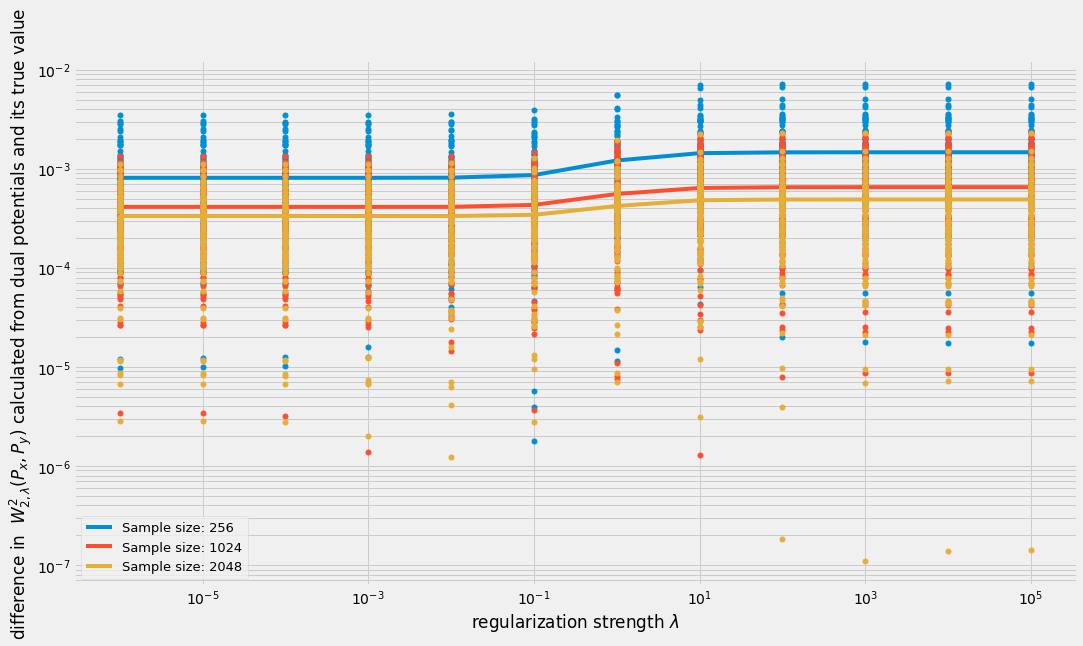

In [17]:
plt.figure()
legend = []
for n_pts in n_pts_to_calculate_distance_list:
    l = plt.semilogx(eps_list, relative_differences_avg[n_pts], label = 'Sample size: {:d}'.format(n_pts))
    plt.loglog(np.repeat(eps_list, n_trials), np.stack(np.abs(relative_differences[n_pts])).T.flatten(), 
                 c=l[0].get_color(), ls='',marker='o',ms=5)
# plt.semilogx(eps_list, entropicW_distance_via_dual_potentials)
plt.xlabel('regularization strength $\lambda$')
plt.ylabel("difference in  $W_{2,\lambda}^2(P_x, P_y)$ calculated from dual potentials and its true value")
plt.legend()
plt.grid('on', 'both')
plt.show()

### Below we compare the different ways of calculating entropic w2 distance

In [18]:
n_trials = 10
n_pts_to_calculate_distance = 256
mean_x = np.random.randn(data_dim)
mean_y = np.random.randn(data_dim)
K_x = np.eye(data_dim) / np.sqrt(data_dim)
K_y = np.eye(data_dim) / np.sqrt(data_dim)
data_shape = (n_pts_to_calculate_distance, data_dim)

In [19]:
eps_list = np.power(10., np.arange(-6, 6))
entropicW_distance_true = [true_entropic_2Wasserstein_loss_gaussian(0,0,K_x,K_y, eps) 
                           for eps in eps_list]
dual_potentials_true = [true_entropic_2Wasserstein_loss_dual_potentials_gaussian(0,0,K_x,K_y, eps) 
                           for eps in eps_list]

In [20]:
calculated_distances = {normalize_probability:{} for normalize_probability in [True, False]}
for normalize_probability in [True, False]:
    for normalize_distances in [True, False]:
        calculated_distances_geomloss_potentials_primal = {eps:[] for eps in eps_list}
        calculated_distances_geomloss_potentials_dual = {eps:[] for eps in eps_list}
        calculated_distances_geomloss = {eps:[] for eps in eps_list}
        calculated_distances_true_potentials_primal = {eps:[] for eps in eps_list}
        calculated_distances_true_potentials_dual = {eps:[] for eps in eps_list}
        for j,epsilon in enumerate(eps_list):
            for i in range(n_trials):
                print("Trial: {}, epsilon {}, normalize probability: {}, normalize distances: {}".format(
                i, epsilon, normalize_probability, normalize_distances))
                x = torch.tensor(np.random.randn(*data_shape).dot(scipy.linalg.sqrtm(K_x)))
                y = torch.tensor(np.random.randn(*data_shape).dot(scipy.linalg.sqrtm(K_y)))
                EntropicW_distance_expected = entropic_2Wasserstein_loss(x, y, epsilon)
                EntropicW_distance_potentials = entropic_2Wasserstein_loss(x, y, epsilon, return_potentials=True)
                # Calculate distances from potentials
                potential_x, potential_y = EntropicW_distance_potentials
                EntropicW_distance_dual_calculated_from_geomloss_potentials = entropic_2Wasserstein_loss_dual_from_potentials(x, y, epsilon,
                                                                                                                potential_x,
                                                                                                                potential_y)
                EntropicW_distance_primal_calculated_from_geomloss_potentials = entropic_2Wasserstein_loss_primal_from_potentials(x, y, epsilon,
                                                                                                                    potential_x,
                                                                                                                    potential_y,
                                                                                                                    normalize_probability=normalize_probability,
                                                                                                                    normalize_distances=normalize_distances)
                
                
                potential_x, potential_y = dual_potentials_true[j][0](x), dual_potentials_true[j][1](y)
                EntropicW_distance_dual_calculated_from_true_potentials = entropic_2Wasserstein_loss_dual_from_potentials(x, y, epsilon,
                                                                                                                potential_x,
                                                                                                                potential_y)
                EntropicW_distance_primal_calculated_from_true_potentials = entropic_2Wasserstein_loss_primal_from_potentials(x, y, epsilon,
                                                                                                                    potential_x,
                                                                                                                    potential_y,
                                                                                                                    normalize_probability=normalize_probability,
                                                                                                                    normalize_distances=normalize_distances)
                
                calculated_distances_geomloss_potentials_primal[epsilon].append(EntropicW_distance_primal_calculated_from_geomloss_potentials.data)
                calculated_distances_geomloss_potentials_dual[epsilon].append(EntropicW_distance_dual_calculated_from_geomloss_potentials.data)
                calculated_distances_true_potentials_primal[epsilon].append(EntropicW_distance_primal_calculated_from_true_potentials.data)
                calculated_distances_true_potentials_dual[epsilon].append(EntropicW_distance_dual_calculated_from_true_potentials.data)
                calculated_distances_geomloss[epsilon].append(EntropicW_distance_expected.data)
        calculated_distances[normalize_probability][normalize_distances] = (calculated_distances_geomloss_potentials_primal, 
                                                                           calculated_distances_geomloss_potentials_dual,
                                                                           calculated_distances_geomloss,
                                                                           calculated_distances_true_potentials_primal,
                                                                           calculated_distances_true_potentials_dual)

Trial: 0, epsilon 1e-06, normalize probability: True, normalize distances: True
Trial: 1, epsilon 1e-06, normalize probability: True, normalize distances: True
Trial: 2, epsilon 1e-06, normalize probability: True, normalize distances: True
Trial: 3, epsilon 1e-06, normalize probability: True, normalize distances: True
Trial: 4, epsilon 1e-06, normalize probability: True, normalize distances: True
Trial: 5, epsilon 1e-06, normalize probability: True, normalize distances: True
Trial: 6, epsilon 1e-06, normalize probability: True, normalize distances: True
Trial: 7, epsilon 1e-06, normalize probability: True, normalize distances: True
Trial: 8, epsilon 1e-06, normalize probability: True, normalize distances: True
Trial: 9, epsilon 1e-06, normalize probability: True, normalize distances: True
Trial: 0, epsilon 1e-05, normalize probability: True, normalize distances: True
Trial: 1, epsilon 1e-05, normalize probability: True, normalize distances: True
Trial: 2, epsilon 1e-05, normalize proba

Trial: 6, epsilon 10000.0, normalize probability: True, normalize distances: True
Trial: 7, epsilon 10000.0, normalize probability: True, normalize distances: True
Trial: 8, epsilon 10000.0, normalize probability: True, normalize distances: True
Trial: 9, epsilon 10000.0, normalize probability: True, normalize distances: True
Trial: 0, epsilon 100000.0, normalize probability: True, normalize distances: True
Trial: 1, epsilon 100000.0, normalize probability: True, normalize distances: True
Trial: 2, epsilon 100000.0, normalize probability: True, normalize distances: True
Trial: 3, epsilon 100000.0, normalize probability: True, normalize distances: True
Trial: 4, epsilon 100000.0, normalize probability: True, normalize distances: True
Trial: 5, epsilon 100000.0, normalize probability: True, normalize distances: True
Trial: 6, epsilon 100000.0, normalize probability: True, normalize distances: True
Trial: 7, epsilon 100000.0, normalize probability: True, normalize distances: True
Trial: 8

Trial: 9, epsilon 100.0, normalize probability: True, normalize distances: False
Trial: 0, epsilon 1000.0, normalize probability: True, normalize distances: False
Trial: 1, epsilon 1000.0, normalize probability: True, normalize distances: False
Trial: 2, epsilon 1000.0, normalize probability: True, normalize distances: False
Trial: 3, epsilon 1000.0, normalize probability: True, normalize distances: False
Trial: 4, epsilon 1000.0, normalize probability: True, normalize distances: False
Trial: 5, epsilon 1000.0, normalize probability: True, normalize distances: False
Trial: 6, epsilon 1000.0, normalize probability: True, normalize distances: False
Trial: 7, epsilon 1000.0, normalize probability: True, normalize distances: False
Trial: 8, epsilon 1000.0, normalize probability: True, normalize distances: False
Trial: 9, epsilon 1000.0, normalize probability: True, normalize distances: False
Trial: 0, epsilon 10000.0, normalize probability: True, normalize distances: False
Trial: 1, epsilo

Trial: 2, epsilon 100.0, normalize probability: False, normalize distances: True
Trial: 3, epsilon 100.0, normalize probability: False, normalize distances: True
Trial: 4, epsilon 100.0, normalize probability: False, normalize distances: True
Trial: 5, epsilon 100.0, normalize probability: False, normalize distances: True
Trial: 6, epsilon 100.0, normalize probability: False, normalize distances: True
Trial: 7, epsilon 100.0, normalize probability: False, normalize distances: True
Trial: 8, epsilon 100.0, normalize probability: False, normalize distances: True
Trial: 9, epsilon 100.0, normalize probability: False, normalize distances: True
Trial: 0, epsilon 1000.0, normalize probability: False, normalize distances: True
Trial: 1, epsilon 1000.0, normalize probability: False, normalize distances: True
Trial: 2, epsilon 1000.0, normalize probability: False, normalize distances: True
Trial: 3, epsilon 1000.0, normalize probability: False, normalize distances: True
Trial: 4, epsilon 1000.0

Trial: 5, epsilon 1.0, normalize probability: False, normalize distances: False
Trial: 6, epsilon 1.0, normalize probability: False, normalize distances: False
Trial: 7, epsilon 1.0, normalize probability: False, normalize distances: False
Trial: 8, epsilon 1.0, normalize probability: False, normalize distances: False
Trial: 9, epsilon 1.0, normalize probability: False, normalize distances: False
Trial: 0, epsilon 10.0, normalize probability: False, normalize distances: False
Trial: 1, epsilon 10.0, normalize probability: False, normalize distances: False
Trial: 2, epsilon 10.0, normalize probability: False, normalize distances: False
Trial: 3, epsilon 10.0, normalize probability: False, normalize distances: False
Trial: 4, epsilon 10.0, normalize probability: False, normalize distances: False
Trial: 5, epsilon 10.0, normalize probability: False, normalize distances: False
Trial: 6, epsilon 10.0, normalize probability: False, normalize distances: False
Trial: 7, epsilon 10.0, normalize

The regularized distances calculated for different numerical stability parameters

In [21]:
np.stack([calculated_distances_geomloss_potentials_primal[eps] for eps in eps_list]).mean(1)

array([5.97826730e+28, 2.34083684e+22, 2.53338917e+19, 1.05583929e+05,
       2.21797256e+01, 8.53321447e+00, 9.42198147e+00, 1.10176243e+01,
       1.12448811e+01, 1.13789636e+01, 1.12947068e+01, 1.12853826e+01])

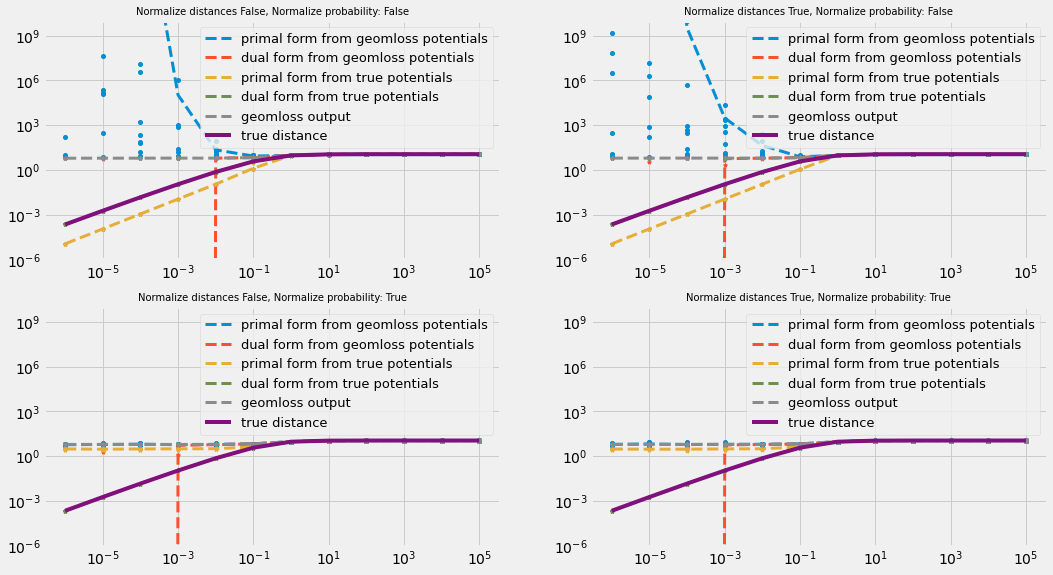

In [22]:
fig, axs = plt.subplots(figsize = (16,9), ncols=2, nrows=2)
for normalize_probability in range(2):
    for normalize_distances in range(2):
        calculated_distances_geomloss_potentials_primal, calculated_distances_geomloss_potentials_dual,\
        calculated_distances_geomloss,calculated_distances_true_potentials_primal,\
        calculated_distances_true_potentials_dual = calculated_distances[normalize_probability][normalize_distances]
        ax = axs[normalize_probability][normalize_distances]
        l = ax.loglog(eps_list, np.stack([calculated_distances_geomloss_potentials_primal[eps] for eps in eps_list]).mean(1), 
                      label='primal form from geomloss potentials', lw = 3, ls = '--')
        ax.loglog(np.repeat(eps_list, n_trials), np.concatenate([calculated_distances_geomloss_potentials_primal[eps] for eps in eps_list]), 
                      ls='',marker='o',ms=4, c = l[0].get_color())
        l = ax.loglog(eps_list, np.stack([calculated_distances_geomloss_potentials_dual[eps] for eps in eps_list]).mean(1), 
                      label='dual form from geomloss potentials', lw = 3, ls = '--')
        ax.loglog(np.repeat(eps_list, n_trials), np.concatenate([calculated_distances_geomloss_potentials_dual[eps] for eps in eps_list]), 
                      ls='',marker='*',ms=4, c = l[0].get_color())
        l = ax.loglog(eps_list, np.stack([calculated_distances_true_potentials_primal[eps] for eps in eps_list]).mean(1), 
                      label='primal form from true potentials', lw = 3, ls = '--')
        ax.loglog(np.repeat(eps_list, n_trials), np.concatenate([calculated_distances_true_potentials_primal[eps] for eps in eps_list]), 
                      ls='',marker='*',ms=4, c = l[0].get_color())
        l = ax.loglog(eps_list, np.stack([calculated_distances_true_potentials_dual[eps] for eps in eps_list]).mean(1), 
                      label='dual form from true potentials', lw = 3, ls = '--')
        ax.loglog(np.repeat(eps_list, n_trials), np.concatenate([calculated_distances_true_potentials_dual[eps] for eps in eps_list]), 
                      ls='',marker='*',ms=4, c = l[0].get_color())
        l = ax.loglog(eps_list, np.stack([calculated_distances_geomloss[eps] for eps in eps_list]).mean(1), 
                      label='geomloss output', lw = 3, ls = '--')
        ax.loglog(np.repeat(eps_list, n_trials), np.concatenate([calculated_distances_geomloss[eps] for eps in eps_list]), 
                      ls='',marker='*',ms=4, c = l[0].get_color())
        ax.loglog(eps_list, entropicW_distance_true, label = 'true distance')
        ax.legend()
        ax.set_ylim(1e-6, 1e10)
        ax.set_title("Normalize distances {}, Normalize probability: {}".format(bool(normalize_distances),
                                                                               bool(normalize_probability)),
                    fontdict={'size':10})
plt.grid('on','both')
plt.show()

Averaged relative difference

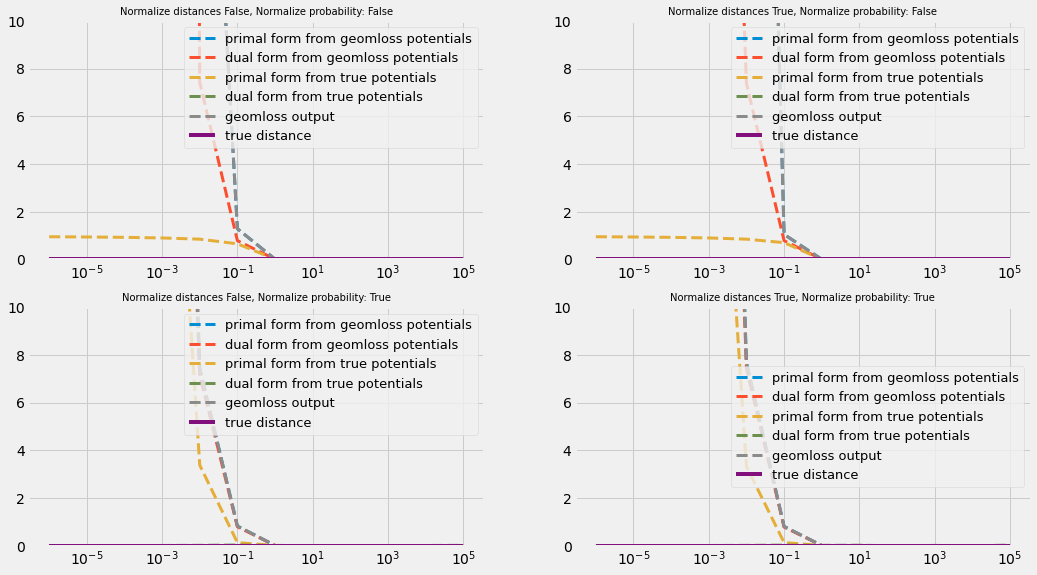

In [23]:
fig, axs = plt.subplots(figsize = (16,9), ncols=2, nrows=2)
entropicW_distance_true = np.array(entropicW_distance_true)
for normalize_probability in range(2):
    for normalize_distances in range(2):
        calculated_distances_geomloss_potentials_primal, calculated_distances_geomloss_potentials_dual,\
        calculated_distances_geomloss,calculated_distances_true_potentials_primal,\
        calculated_distances_true_potentials_dual = calculated_distances[normalize_probability][normalize_distances]
        ax = axs[normalize_probability][normalize_distances]
        ax.semilogx(eps_list, (np.abs(np.stack([calculated_distances_geomloss_potentials_primal[eps] for eps in eps_list])
                               - entropicW_distance_true[:,np.newaxis])).mean(1) / entropicW_distance_true, 
                      label='primal form from geomloss potentials', lw = 3, ls = '--')
        ax.semilogx(eps_list, (np.abs(np.stack([calculated_distances_geomloss_potentials_dual[eps] for eps in eps_list])
                               - entropicW_distance_true[:,np.newaxis])).mean(1) / entropicW_distance_true, 
                      label='dual form from geomloss potentials', lw = 3, ls = '--')
        ax.semilogx(eps_list, (np.abs(np.stack([calculated_distances_true_potentials_primal[eps] for eps in eps_list])
                               - entropicW_distance_true[:,np.newaxis])).mean(1) / entropicW_distance_true, 
                      label='primal form from true potentials', lw = 3, ls = '--')
        ax.semilogx(eps_list, (np.abs(np.stack([calculated_distances_true_potentials_dual[eps] for eps in eps_list])
                               - entropicW_distance_true[:,np.newaxis])).mean(1) / entropicW_distance_true, 
                      label='dual form from true potentials', lw = 3, ls = '--')
        ax.semilogx(eps_list, (np.abs(np.stack([calculated_distances_geomloss_potentials_primal[eps] for eps in eps_list])
                               - entropicW_distance_true[:,np.newaxis])).mean(1) / entropicW_distance_true, 
                      label='geomloss output', lw = 3, ls = '--')
        ax.semilogx(eps_list, (entropicW_distance_true-entropicW_distance_true)/entropicW_distance_true,
                    label = 'true distance')
        ax.legend()
        ax.set_ylim(0.0, 10.0)
        ax.set_title("Normalize distances {}, Normalize probability: {}".format(bool(normalize_distances),
                                                                               bool(normalize_probability)),
                    fontdict={'size':10})
plt.grid('on','both')
plt.show()

##### Conclusion:
We won't normalize anything at all